In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from numba import njit
import pandas as pd

In [2]:
@njit(fastmath=True)
def scan_qty(lon_c_arr, lat_c_arr, qty_arr, count_arr, 
             lon, lat, qty, cone_size, lon_step, lat_step, cos_weight=True,
             ):
    """
    Scan and average to make quantity sky map. Mainly use for bulk flow calculation, 
    namely to calculate the line of sight velocity maps. This is the numba accelerated
    main calculation of the code.
    """

    # unit conversions
    theta = cone_size # set alias
    theta_rad = theta * np.pi / 180
    lat_rad = lat * np.pi / 180 # the memory load is not very high so we can do this
    lon_rad = lon * np.pi / 180

    n_tot = len(lon)

    for lon_c in range(-180, 180):

        if lon_c % lon_step != 0: # numba parallel only supports step size of 1
            continue
        lon_c_rad = lon_c * np.pi / 180

        for lat_c in range(-90, 90):

            if lat_c % lat_step != 0: # if you are wondering, 0 % lat_step = 0
                continue
            lat_c_rad = lat_c * np.pi / 180

            a = np.pi / 2 - lat_c_rad # center of cone to zenith
            b = np.pi / 2 - lat_rad   # cluster to zenith
            costheta = np.cos(a)*np.cos(b) + np.sin(a)*np.sin(b)*np.cos(lon_rad - lon_c_rad) # cosθ=cosa*cosb+sina*sinb*cosA
            mask = costheta > np.cos(theta_rad)
            n_clusters = np.sum(mask)

            # Mask selection
            cone_qty = qty[mask]

            # Indexing
            idx = (lon_c+180)//lon_step * 180//lat_step + (lat_c+90)//lat_step

            # If no cluster in the cone
            if np.sum(cone_qty) == 0:
                lon_c_arr[idx] = lon_c
                lat_c_arr[idx] = lat_c
                qty_arr[idx]   = 0
                continue

            # Inverse cosine weighting to emphasize the direction
            if cos_weight:
                weight = costheta[mask]
            else:
                weight = np.ones(n_clusters)

            # Weighted mean
            result = np.sum(cone_qty*weight)/np.sum(mask)

            # Output
            lon_c_arr[idx] = lon_c
            lat_c_arr[idx] = lat_c
            qty_arr[idx]   = result
            count_arr[idx] = np.sum(mask)

            # print(f'lon_c: {lon_c}, lat_c: {lat_c}, qty: {result}')

    return lon_c_arr, lat_c_arr, qty_arr, count_arr

In [3]:
def make_los_v_map(data, zmask, cone_size=45, lon_step=4, lat_step=2):
    """
    Scan and average to make quantity sky map. Mainly use for bulk flow calculation, 
    namely to calculate the line of sight velocity maps.
    """
    # data = data[:n_clusters]
    data = data[zmask]

    # Coordinates
    lon = data['phi_on_lc']
    lat = data['theta_on_lc']
    lon = np.array(lon)
    lat = np.array(lat)

    # Allocate memory
    n_steps = 360//lon_step * 180//lat_step
    qty_arr   = np.zeros(n_steps)
    lon_c_arr = np.zeros(n_steps)
    lat_c_arr = np.zeros(n_steps)
    count_arr = np.zeros(n_steps)

    # Peculiar los velocity
    vx = np.array(data['Vx'])                 # velocities in km/s
    vy = np.array(data['Vy'])
    vz = np.array(data['Vz'])

    x = np.array(data['x_lc'])
    y = np.array(data['y_lc'])
    z = np.array(data['z_lc'])

    los_v = (vx*x + vy*y + vz*z) / (x**2 + y**2 + z**2)**0.5 # in km/s
    los_v = np.array(los_v)

    # v_vecs = los_v[...,None] * np.column_stack([x,y,z]) / (x[...,None]**2 + y[...,None]**2 + z[...,None]**2)**0.5

    # Scan. los velocity is in fact a vector, and the contribution to center cone direction should be weighted with a cosine factor
    Glon, Glat, los_v_map, count_map = scan_qty(lon_c_arr, lat_c_arr, qty_arr, count_arr,
                                    lon, lat, los_v, cone_size, lon_step, lat_step, cos_weight=True)
    return Glon, Glat, los_v_map, count_map

## Summing each cone to make a map, without assuming dipole

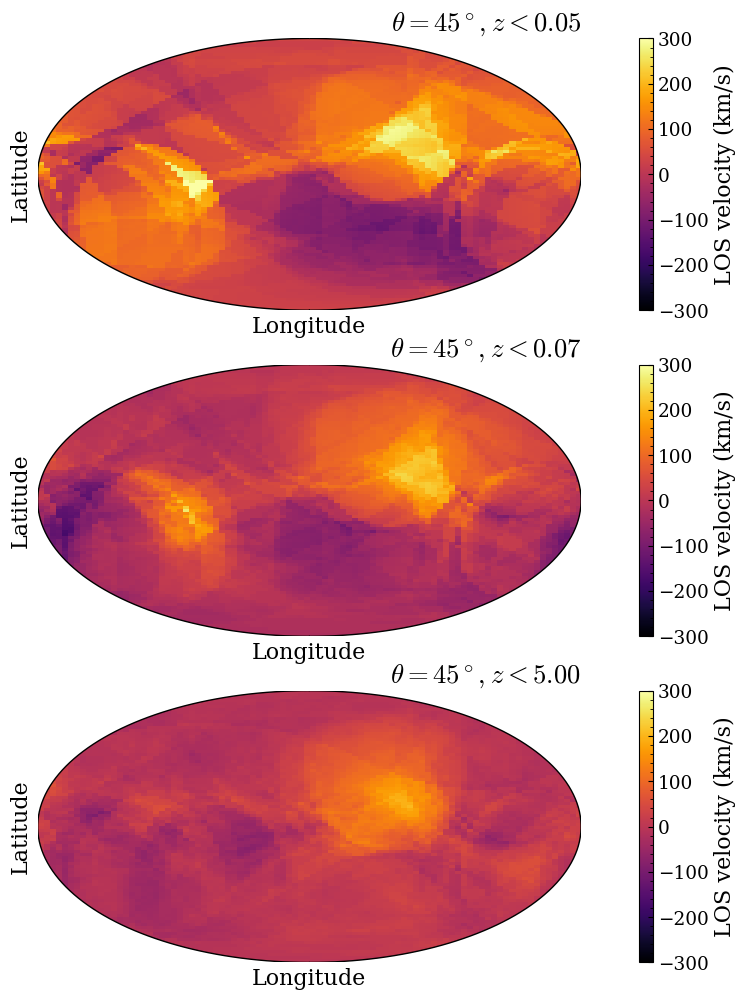

In [4]:
import sys
sys.path.append('../tools/')
import clusterplot as cp
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap
# Use hammer projection
m = Basemap(projection='hammer', lon_0=0)

# -------------------------------||Parameters||---------------------------------
cone_size = 45
lon_step = 4
lat_step = 2
n_clusters = 313
data = pd.read_csv('../data/samples_in_lightcone0_with_trees_duplicate_excision.csv')
#-------------------------------------------------------------------------------


# Only 313 highest Lcore/Ltot clusters
data = data[:n_clusters]

redshift = data['ObservedRedshift']
fig, axes = plt.subplots(3, 1, figsize=(15, 12))
for zmax, ax in zip([0.05, 0.07, 5], axes):
    # Select redshift range
    zmask = (redshift < zmax)
    
    # Calculate los velocity map
    _,_,los_v_map,_ = make_los_v_map(data, zmask, cone_size=cone_size, lon_step=lon_step, lat_step=lat_step)
    
    # Plot the map
    cp._sky_map_(los_v_map, colorbar_label='LOS velocity (km/s)', ax=ax, vmin=-300, vmax=300)

    # Set the title
    ax.set_title(f'$\\theta={cone_size}^\\circ, z<{zmax:.2f}$', loc='right')

    # # Highlight some directions
    # m.scatter(51.49, 13.34, marker='o', ax=ax, latlon=True, edgecolor='r', facecolor='none', s=100)
    # m.scatter(50.17, 19.97, marker='o', ax=ax, latlon=True, edgecolor='r', facecolor='none', s=100)

plt.show()

## True bulk flow, amplitude and direction.
### Method 1: Summing each cluster and average over them.
Without assuming dipole. The bulk flow is the averaged velocity of each cluster.

In [5]:
import astropy.coordinates as coord
data = pd.read_csv('../data/samples_in_lightcone0_with_trees_duplicate_excision.csv')

# Consider only our small samples?
data = data[:n_clusters]

redshift = data['ObservedRedshift']
print(redshift.min(), redshift.max())

# Peculiar los velocity
vx = np.array(data['Vx'])                 # velocities in km/s
vy = np.array(data['Vy'])
vz = np.array(data['Vz'])

x = np.array(data['x_lc'])
y = np.array(data['y_lc'])
z = np.array(data['z_lc'])

los_v = (vx*x + vy*y + vz*z) / (x**2 + y**2 + z**2)**0.5 # in km/s
los_v = np.array(los_v)

v_vecs = los_v[...,None] * np.column_stack([x,y,z]) / (x[...,None]**2 + y[...,None]**2 + z[...,None]**2)**0.5


for zmax in np.arange(0.03, redshift.max()+0.01, 0.02):
    zmask = (redshift < zmax)

    # Mask and sum
    bulk_v = np.sum(v_vecs[zmask,:], axis=0)/np.sum(zmask)
    r, b, l = coord.cartesian_to_spherical(bulk_v[0], bulk_v[1], bulk_v[2]) # r, lat, lon
    print(f"z<{zmax:.2f}, {np.sum(zmask)} haloes {r:.2f} km/s ({l.to('deg').value:.2f}, {b.to('deg').value:.2f})")
    # break

0.0106927399700134 0.1682769161224142
z<0.03, 29 haloes 50.52 km/s (153.31, 11.05)
z<0.05, 88 haloes 23.30 km/s (151.87, 65.88)
z<0.07, 161 haloes 32.19 km/s (52.66, 52.68)
z<0.09, 214 haloes 39.24 km/s (60.89, 43.65)
z<0.11, 248 haloes 38.65 km/s (57.35, 47.49)
z<0.13, 282 haloes 25.49 km/s (46.30, 32.08)
z<0.15, 300 haloes 23.43 km/s (42.82, 23.94)
z<0.17, 313 haloes 20.34 km/s (50.17, 19.97)


In [6]:
np.max((v_vecs[:,0]**2 + v_vecs[:,1]**2 + v_vecs[:,2]**2)**0.5)

1468.4738951765162

### Method 2: Maximum dipole flow of opposing direction

In [7]:
import sys
sys.path.append('/data1/yujiehe/anisotropy-flamingo')
import tools.clusterfit as cf

@njit(fastmath=True)
def find_max_dipole_flow(Glon, Glat, los_v_map, count_map):
    # Find the maximum dipole flow
    max_ubf_dp = 0
    for lon, lat in zip(Glon, Glat):
        if lon < 0: # only do half of the sky
            continue

        # current direction
        los_v = los_v_map[(Glon == lon) & (Glat == lat)]
        count = count_map[(Glon == lon) & (Glat == lat)]

        # get the dipole direction
        dp_lon, dp_lat = cf.opposite_direction(lon, lat)
        dp_mask = (Glon == dp_lon) & (Glat == dp_lat)
        dp_los_v = los_v_map[dp_mask]
        dp_count = count_map[dp_mask]

        # calculate the dipole flow, weighted using number of clusters
        if np.sum(count + dp_count) > 0:
            ubf_dp = (los_v*count - dp_los_v*dp_count)/(count + dp_count)
            ubf_dp = ubf_dp[0]
            if np.abs(ubf_dp) > np.abs(max_ubf_dp):
                if ubf_dp > 0:
                    max_ubf_dp = ubf_dp
                    max_bf_lon = lon
                    max_bf_lat = lat
                else:
                    max_ubf_dp = -max_ubf_dp
                    max_bf_lon = dp_lon
                    max_bf_lat = dp_lat

    return max_ubf_dp, max_bf_lon, max_bf_lat

In [9]:
cone_size = 45
n_clusters=313

data = pd.read_csv('../data/samples_in_lightcone0_with_trees_duplicate_excision.csv')
def ubf_z(data):
    # Only 313 highest Lcore/Ltot clusters
    data = data[:n_clusters]
    redshift = data['ObservedRedshift']

    # Note down stuff we want to plot
    zmaxs = []
    ubfs = []

    for zmax in np.arange(0.03, redshift.max()+0.01, 0.01):
        zmask = (redshift < zmax)
        Glon, Glat, los_v_map, count_map = make_los_v_map(data, zmask, cone_size=cone_size, lon_step=lon_step, lat_step=lat_step)

        # TODO: add weighted average according to number of clusters in each cone
        bulk_vx = np.average(los_v_map * np.cos(Glat * np.pi / 180) * np.cos(Glon * np.pi / 180), weights=count_map)
        bulk_vy = np.average(los_v_map * np.cos(Glat * np.pi / 180) * np.sin(Glon * np.pi / 180), weights=count_map)
        bulk_vz = np.average(los_v_map * np.sin(Glat * np.pi / 180), weights=count_map)
        r, b, l = coord.cartesian_to_spherical(bulk_vx, bulk_vy, bulk_vz) # r, lat, lon
        print(f"z<{zmax:.2f}, {np.sum(zmask)} haloes {r:.2f} km/s ({l.to('deg').value:.2f}, {b.to('deg').value:.2f})")
        #print(Glon[los_v_map.argmax()], Glat[los_v_map.argmax()], los_v_map.max())

        # Find the maximum dipole flow
        max_ubf_dp, max_bf_lon, max_bf_lat = find_max_dipole_flow(Glon, Glat, los_v_map, count_map)
        print(f"max dipole flow: {max_ubf_dp} km/s at ({max_bf_lon}, {max_bf_lat})")

        # Save the maximum dipole flow
        ubfs.append(max_ubf_dp)
        zmaxs.append(zmax)
    return zmaxs, ubfs

z<0.03, 29 haloes 25.80 km/s (154.61, 11.82)
max dipole flow: 428.06894265720354 km/s at (72.0, 30.0)
z<0.04, 61 haloes 31.29 km/s (189.88, 73.84)
max dipole flow: 208.93831929911167 km/s at (68.0, 0.0)
z<0.05, 88 haloes 13.83 km/s (166.96, 70.87)
max dipole flow: 189.5877052283117 km/s at (120.0, 14.0)
z<0.06, 138 haloes 21.45 km/s (45.43, 75.34)
max dipole flow: 109.25953285625965 km/s at (16.0, 8.0)
z<0.07, 161 haloes 21.07 km/s (53.15, 62.28)
max dipole flow: 132.19157892156602 km/s at (16.0, 24.0)
z<0.08, 184 haloes 27.55 km/s (74.62, 66.65)
max dipole flow: 138.3005138137593 km/s at (92.0, 8.0)
z<0.09, 214 haloes 25.52 km/s (61.53, 56.52)
max dipole flow: 146.79854869969554 km/s at (16.0, 24.0)
z<0.10, 227 haloes 21.65 km/s (66.00, 51.39)
max dipole flow: 145.80502888040695 km/s at (60.0, 12.0)
z<0.11, 248 haloes 26.69 km/s (57.46, 61.39)
max dipole flow: 151.75198421289306 km/s at (60.0, 12.0)
z<0.12, 267 haloes 15.43 km/s (51.56, 41.03)
max dipole flow: 140.25298477983503 km/s 

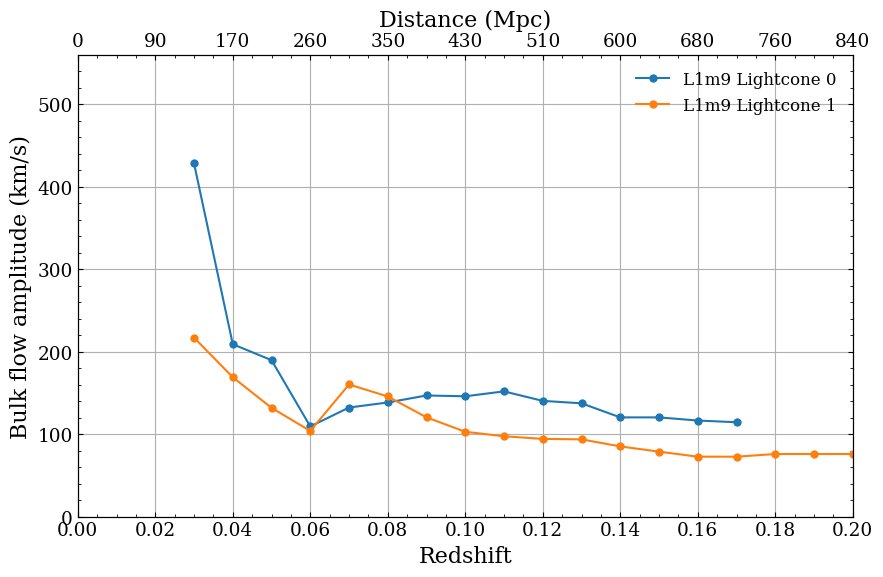

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=68.1, Om0=0.306)
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate and plot the bulk flow for the first lightcone
data = pd.read_csv('../data/samples_in_lightcone0_with_trees_duplicate_excision.csv')
zmaxs, ubfs = ubf_z(data) # ubf_z returns a list
zmaxs = np.array(zmaxs)

ax.plot(zmaxs, ubfs, marker='o', label='L1m9 Lightcone 0')

# Calculate and plot the bulk flow for the second lightcone
data = pd.read_csv('../data/samples_in_lightcone1_with_trees_duplicate_excision.csv')
zmaxs, ubfs = ubf_z(data)
zmaxs = np.array(zmaxs) # ubf_z returns a list

ax.plot(zmaxs, ubfs, marker='o', label='L1m9 Lightcone 1')

# Set up the plot
ax.set_xlabel('Redshift')
ax.set_xticks(np.linspace(0, 0.2, 11))

# set a double x label for redshift
ax2 = ax.twiny()
ax2.set_xlim(0, 0.2)
ax2.set_xticks(np.linspace(0, 0.2, 11))                    # this line maps the x values to the new x axis
Dco = cosmo.comoving_distance(np.linspace(0,0.2,11)).value # this line sets the tick labels for the new x axis
xtickslabels = np.round(Dco, -1)
xtickslabels = np.array(xtickslabels, dtype=int) 
ax2.set_xticklabels(xtickslabels) # this line sets the tick labels for the new x axis
ax2.set_xlabel('Distance (Mpc)')

ax.set_ylabel('Bulk flow amplitude (km/s)')
ax.grid(True)
ax.set_xlim(0, 0.2)
ax.set_ylim(0, 560)
ax.legend()
plt.show()

## Compare with the modeled bulk flow

z<0.03, 29 haloes 25.80 km/s (154.61, 11.82)
max dipole flow: 428.06894265720354 km/s at (72.0, 30.0)
z<0.04, 61 haloes 31.29 km/s (189.88, 73.84)
max dipole flow: 208.93831929911167 km/s at (68.0, 0.0)
z<0.05, 88 haloes 13.83 km/s (166.96, 70.87)
max dipole flow: 189.5877052283117 km/s at (120.0, 14.0)
z<0.06, 138 haloes 21.45 km/s (45.43, 75.34)
max dipole flow: 109.25953285625965 km/s at (16.0, 8.0)
z<0.07, 161 haloes 21.07 km/s (53.15, 62.28)
max dipole flow: 132.19157892156602 km/s at (16.0, 24.0)
z<0.08, 184 haloes 27.55 km/s (74.62, 66.65)
max dipole flow: 138.3005138137593 km/s at (92.0, 8.0)
z<0.09, 214 haloes 25.52 km/s (61.53, 56.52)
max dipole flow: 146.79854869969554 km/s at (16.0, 24.0)
z<0.10, 227 haloes 21.65 km/s (66.00, 51.39)
max dipole flow: 145.80502888040695 km/s at (60.0, 12.0)
z<0.11, 248 haloes 26.69 km/s (57.46, 61.39)
max dipole flow: 151.75198421289306 km/s at (60.0, 12.0)
z<0.12, 267 haloes 15.43 km/s (51.56, 41.03)
max dipole flow: 140.25298477983503 km/s 

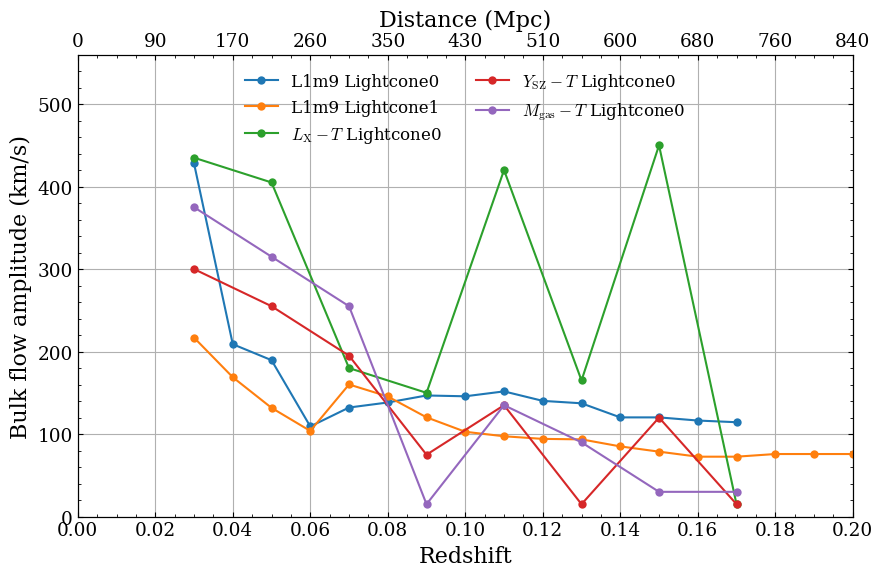

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=68.1, Om0=0.306)
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate and plot the bulk flow for the first lightcone
data = pd.read_csv('../data/samples_in_lightcone0_with_trees_duplicate_excision.csv')
zmaxs, ubfs = ubf_z(data) # ubf_z returns a list
zmaxs = np.array(zmaxs)

ax.plot(zmaxs, ubfs, marker='o', label='L1m9 Lightcone0')

# Calculate and plot the bulk flow for the second lightcone
data = pd.read_csv('../data/samples_in_lightcone1_with_trees_duplicate_excision.csv')
zmaxs, ubfs = ubf_z(data)
zmaxs = np.array(zmaxs) # ubf_z returns a list

ax.plot(zmaxs, ubfs, marker='o', label='L1m9 Lightcone1')

# Set up the plot
ax.set_xlabel('Redshift')
ax.set_xticks(np.linspace(0, 0.2, 11))

# Plot the modeled bulk flow
df = pd.read_csv('../data/fits/bulk_flow_lightcone0.csv')
for relation, label in zip(['LX-T', 'YSZ-T', 'M-T'], ['$L_\\mathrm{{X}}-T$', '$Y_\\mathrm{{SZ}}-T$', '$M_\\mathrm{{gas}}-T$']):
    zmax = df['zmax'].loc[df['scaling_relation']==relation] # Do LX-T for now
    ubfs = df['ubf'].loc[df['scaling_relation']==relation]
    zmaxs = np.array(zmax)
    ax.plot(zmaxs, ubfs, marker='o', label=f'{label} Lightcone0')

# set a double x label for redshift
ax2 = ax.twiny()
ax2.set_xlim(0, 0.2)
ax2.set_xticks(np.linspace(0, 0.2, 11))                    # this line maps the x values to the new x axis
Dco = cosmo.comoving_distance(np.linspace(0,0.2,11)).value # this line sets the tick labels for the new x axis
xtickslabels = np.round(Dco, -1)
xtickslabels = np.array(xtickslabels, dtype=int) 
ax2.set_xticklabels(xtickslabels) # this line sets the tick labels for the new x axis
ax2.set_xlabel('Distance (Mpc)')

ax.set_ylabel('Bulk flow amplitude (km/s)')
ax.grid(True)
ax.set_xlim(0, 0.2)
ax.set_ylim(0, 560)

# legend on the bottom ouside of the plot
ax.legend(loc='upper center', shadow=True, ncol=2)
plt.show()